In [1]:
import numpy as np
import qutip
import matplotlib.pyplot as plt

In [20]:
# Define the collapse operators (Lindblad operators)
num_levels = 6
num_t = 1000
sigma = 96e-9
d_num, A_num = 120, 120
d_interval, A_interval = 460e6, 300e6#460e6, 500e6
anharm = 2 * np.pi * 0.31092e9

In [3]:
def omega_sin(t, args):
    return args["O"] * np.sin(np.pi * t / args["sigma"]) * np.heaviside(t, 1) * np.heaviside(args["sigma"] - t, 1)

In [4]:
def omega_lor(t, args):
    return args["O"] / (1 + ((t - args["dur"] / 2) / args["sigma"])**2) * np.heaviside(t, 1) * np.heaviside(args["dur"] - t, 1)

In [21]:
def omega_rect(t, args):
    return args["O"] * np.heaviside(t, 1) * np.heaviside(args["dur"] - t, 1)

In [22]:
def get_popul(
    num_levels, omega, 
    d_interval, A_interval, 
    d_num, A_num, num_t,
    anharm,
    sigma, dur,
    nsteps=1000
):
    rho0 = qutip.Qobj(
        np.diag(np.maximum(0, 1 - np.arange(num_levels)))
    )
    options = qutip.Options()
    options.nsteps = nsteps
    tlist = np.linspace(0, sigma, num_t)
    d_range = np.linspace(
        - d_interval / 2, 
        d_interval / 2, 
        d_num
    )
    A_range = np.linspace(0, A_interval, A_num)
    tr_probs = []
    for n_d, d in enumerate(d_range):
        values = []
        for n_A, A in enumerate(A_range):
            args_omega = {"O": A, "dur": dur, "sigma": sigma}
            # Define the Hamiltonian (you will need to add your own Hamiltonian terms)
            # H0 = center_detuning * 0.5 * qutip.Qobj(np.diag(np.maximum(0, np.arange(num_levels) - 1) * (np.maximum(0, np.arange(num_levels)))))
            H0 = d * np.diag(np.maximum(0, np.arange(num_levels) - 1) ) \
                + anharm / 2 * np.diag(np.maximum(0, np.arange(num_levels) - 1) * (np.maximum(0, np.arange(num_levels))))
            H0[1,1] = d
            H0 = qutip.Qobj(H0)
            H1 = 0.5 * qutip.Qobj(
                np.diag(np.sqrt(np.arange(num_levels-1) + 1), -1) \
                + np.diag(np.sqrt(np.arange(num_levels-1) + 1), 1) 
            )
            output = qutip.mesolve(
                [
                    H0, 
                    [H1, omega]
                ],
                rho0=rho0,
                args=args_omega,
                tlist=tlist,
                options=options
            )
            values.append(output.states[-1])
            
        tr_probs.append(values)
    return np.array(tr_probs)

In [6]:
tr_probs = get_popul(
    num_levels, omega_sin, 
    d_interval, A_interval, 
    d_num, A_num, num_t,
    anharm,
    sigma, sigma,
    nsteps=1000
)

In [23]:
tr_probs_sq = get_popul(
    num_levels, omega_rect, 
    d_interval, A_interval, 
    d_num, A_num, num_t,
    anharm,
    sigma, sigma,
    nsteps=1000
)

In [7]:
leakage = np.einsum('ijkk', np.abs(tr_probs)[:, :, 2:, 2:])


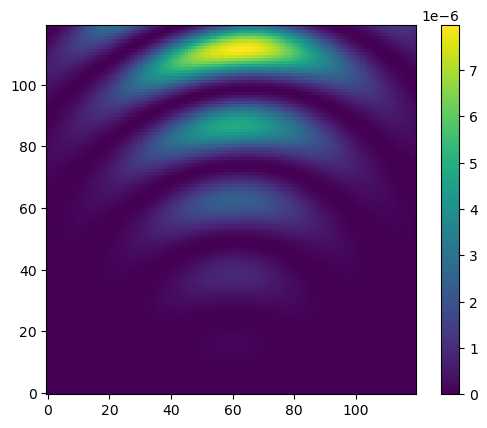

In [8]:
fig1, ax1 = plt.subplots(1,1)
im1 = ax1.imshow(leakage.T,origin="lower")
fig1.colorbar(im1)
plt.show()

In [9]:
leakage_to_very_high_levels = np.einsum('ijkk', np.abs(tr_probs)[:, :, 3:, 3:])

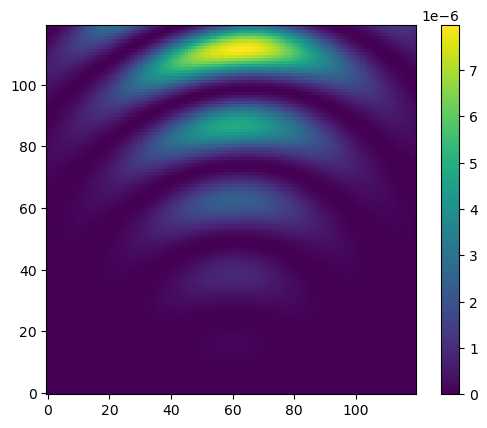

In [10]:
fig3, ax3 = plt.subplots(1,1)
im3 = ax3.imshow((leakage - leakage_to_very_high_levels).T,origin="lower")
fig3.colorbar(im3)
plt.show()

In [11]:
tr = np.abs(tr_probs[:, :, 1, 1])

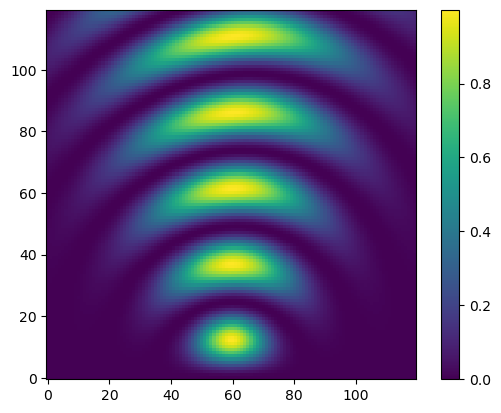

In [12]:
fig2, ax2 = plt.subplots(1,1)
im2 = ax2.imshow(tr.T,origin="lower")
fig2.colorbar(im2)
plt.show()

In [13]:
print(tr.max())

0.9997863126359248


In [14]:
# num_levels, d_interval, A_interval, d_num, A_num, num_t, anharm, sigma, dur = (6, 100e6, 300e9, 50, 50, 10000, 0.3192e9, 96e-9, 6000e-9)

In [15]:
# tr_probs_lor = get_popul(
#     num_levels, omega_lor, 
#     d_interval, A_interval, 
#     d_num, A_num, num_t,
#     anharm,
#     sigma, dur,
#     nsteps=1000
# )

In [16]:
# fig4, ax4 = plt.subplots(1,1)
# im4 = ax4.imshow(np.abs(tr_probs_lor[:,:,1,1].T), origin="lower")
# fig4.colorbar(im4)
# plt.show()

In [19]:
import pickle
with open("C:/Users/Ivo/Documents/qiskit_experiments/sine.pkl", 'wb') as f:
    pickle.dump(tr.T, f)

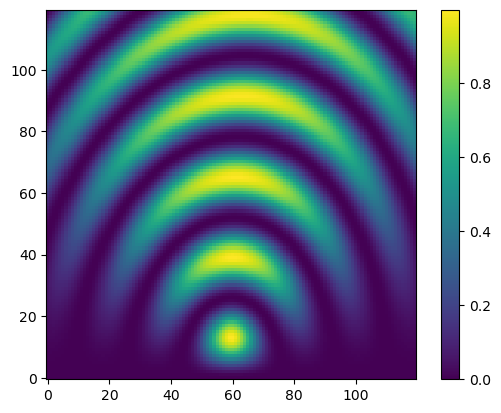

In [24]:
trsq = np.abs(tr_probs[:,:,1,1].T)
fig5, ax5 = plt.subplots(1,1)
im5 = ax5.imshow(trsq,origin="lower")
fig5.colorbar(im5)
plt.show()

In [25]:
with open("C:/Users/Ivo/Documents/qiskit_experiments/sq.pkl", 'wb') as f1:
    pickle.dump(trsq, f1)